# Foundations: Molecular Representations for Machine Learning

**Author**: Hosein Fooladi  
**License**: MIT License

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HFooladi/bayesoptimol/blob/main/notebooks/foundations/molecules_representation.ipynb)

## 1. Overview and Learning Objectives

This notebook explores different ways to represent molecules in formats suitable for machine learning algorithms. Proper molecular representation is a critical first step in applying Bayesian optimization and active learning approaches to drug discovery, as the choice of representation directly impacts the performance of these methods.

**After completing this notebook, you will be able to:**
- Understand the importance of molecular representations in machine learning for drug discovery
- Implement and compare different molecular encoding methods including SMILES strings, fingerprints, and descriptors
- Calculate molecular similarity using various kernel functions
- Select appropriate representations for different machine learning tasks
- Visualize and interpret relationships between molecular structures and their representations

**Prerequisites:**
- Basic knowledge of chemistry and organic structures
- Familiarity with Python programming
- Understanding of basic machine learning concepts

---

## 2. Setup and Dependencies

Let's begin by installing and importing all necessary packages.

In [ ]:
# Install required packages
!pip install -q rdkit-pypi scikit-learn pandas matplotlib seaborn tqdm umap-learn

Uncomment if using Google Colab to show plots inline

#from google.colab import output

#output.enable_custom_widget_manager()

In [9]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, PandasTools, MACCSkeys
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.AtomPairs import Pairs, Torsions
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import warnings
import os
import time
from tqdm.notebook import tqdm
from IPython.display import display, HTML

In [3]:
# Set plotting style
#plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)

In [4]:
# Configure warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [5]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [10]:
# Display versions for reproducibility
import sys
print(f"Python version: {sys.version}")
print(f"RDKit version: {rdkit.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
RDKit version: 2024.03.5
NumPy version: 1.26.0
Pandas version: 2.2.2


## 3. Background and Theory

### 3.1 Why Molecular Representations Matter

When applying machine learning to chemical problems, we need to convert molecular structures into numerical or vector representations that algorithms can process. The choice of representation can significantly impact:

- **Model performance**: Different representations capture different aspects of molecular structure and properties
- **Computational efficiency**: Some representations are more compact or easier to process
- **Interpretability**: Some representations maintain a clear connection to chemical features
- **Applicability**: Certain tasks may require specific types of information about molecules

The challenge lies in encoding the complex 3D structures and chemical properties of molecules into formats that preserve the relevant information while being suitable for machine learning algorithms.

### 3.2 Key Requirements for Molecular Representations

An ideal molecular representation for machine learning should have several important properties:

- **Invariance to symmetry operations**: Rotation, translation, or reordering of atoms shouldn't change the representation
- **Uniqueness**: Different molecules should have different representations
- **Completeness**: Contains all relevant structural information
- **Smoothness**: Similar molecules should have similar representations
- **Computational efficiency**: Can be calculated quickly for large datasets

Different representations make different trade-offs among these requirements. Let's explore this with a visualization:

In [11]:
# @title Visualization of Representation Trade-offs { display-mode: "form" }
# Create a radar chart to visualize trade-offs
def plot_representation_tradeoffs():
    # Categories and representations
    categories = ['Invariance', 'Uniqueness', 'Completeness', 'Smoothness', 'Efficiency']
    representations = ['SMILES/String', 'Fingerprints', 'Descriptors', 'Graphs', '3D Coordinates']
    
    # Ratings for each representation (0-5 scale)
    # These are subjective ratings for illustration
    data = np.array([
        [3, 4, 3, 2, 5],  # SMILES/String
        [5, 3, 3, 4, 5],  # Fingerprints
        [5, 2, 2, 4, 4],  # Descriptors
        [5, 5, 4, 5, 3],  # Graphs
        [3, 5, 5, 5, 2]   # 3D Coordinates
    ])
    
    # Create radar chart
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Add category labels
    plt.xticks(angles[:-1], categories, size=12)
    
    # Add representation data
    for i, rep in enumerate(representations):
        values = data[i].tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, label=rep)
        ax.fill(angles, values, alpha=0.1)
    
    # Customize chart
    ax.set_ylim(0, 5)
    plt.yticks([1, 2, 3, 4, 5], ['1', '2', '3', '4', '5'], color='grey', size=10)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Trade-offs Between Different Molecular Representations', size=15)
    
    plt.tight_layout()
    plt.show()
    
    # Explanation
    print("Explanation of representation trade-offs:")
    print("- SMILES strings are efficient and relatively unique, but aren't invariant to atom ordering.")
    print("- Fingerprints provide good invariance and efficiency, with moderate uniqueness and completeness.")
    print("- Descriptors are invariant but may lose uniqueness as they compress molecular information.")
    print("- Graph representations maintain more structural information but are less computationally efficient.")
    print("- 3D coordinate representations capture complete structural information but are sensitive to conformation\n  and less efficient to process.")

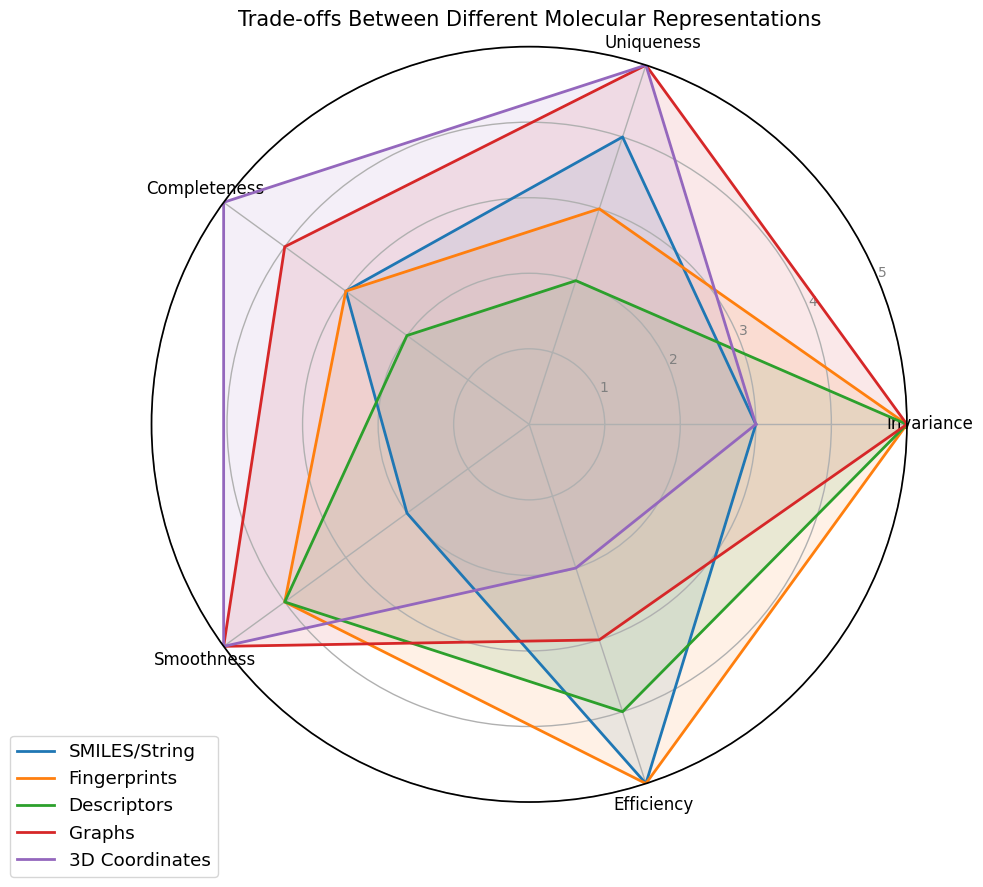

Explanation of representation trade-offs:
- SMILES strings are efficient and relatively unique, but aren't invariant to atom ordering.
- Fingerprints provide good invariance and efficiency, with moderate uniqueness and completeness.
- Descriptors are invariant but may lose uniqueness as they compress molecular information.
- Graph representations maintain more structural information but are less computationally efficient.
- 3D coordinate representations capture complete structural information but are sensitive to conformation
  and less efficient to process.


In [12]:
# Plot the trade-offs
plot_representation_tradeoffs()

### 3.3 Types of Molecular Representations

Molecular representations fall into several categories:

1. **String-based**: Linear text notations like SMILES and InChI
2. **Fingerprint-based**: Bit vectors encoding presence of substructures or features
3. **Descriptor-based**: Numerical values describing physical and chemical properties
4. **Graph-based**: Molecules as graphs with atoms as nodes and bonds as edges
5. **3D-based**: Three-dimensional coordinates and spatial information

Let's visualize this categorization:

In [13]:
# @title Molecular Representation Hierarchy { display-mode: "form" }
from IPython.display import Image
from IPython.core.display import HTML

In [14]:
# Create a compact representation of the hierarchy using HTML
html = """
<div style="background-color:#f8f9fa; padding:20px; border-radius:10px;">
<h3 style="text-align:center;">Molecular Representation Hierarchy</h3>
<ul style="list-style-type:none; padding-left:20px;">
  <li>
    <span style="font-weight:bold;">🔤 String-based</span>
    <ul>
      <li>SMILES: <code>CC(=O)OC1=CC=CC=C1C(=O)O</code> (Aspirin)</li>
      <li>InChI: <code>InChI=1S/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)12/h2-5H,1H3,(H,11,12)</code></li>
      <li>SELFIES: Self-referencing embedded strings</li>
    </ul>
  </li>
  <li>
    <span style="font-weight:bold;">👾 Fingerprint-based</span>
    <ul>
      <li>Morgan/ECFP: Extended connectivity fingerprints</li>
      <li>MACCS: 166 predefined structural keys</li>
      <li>Atom Pairs: Atom types and topological distances</li>
      <li>Topological Torsions: Paths of 4 connected atoms</li>
    </ul>
  </li>
  <li>
    <span style="font-weight:bold;">🔢 Descriptor-based</span>
    <ul>
      <li>Physical: Molecular weight, logP, TPSA</li>
      <li>Constitutional: Atom counts, bond counts</li>
      <li>Topological: Molecular connectivity indices</li>
      <li>Electronic: Partial charges, polarizability</li>
    </ul>
  </li>
  <li>
    <span style="font-weight:bold;">📊 Graph-based</span>
    <ul>
      <li>Adjacency matrix representation</li>
      <li>Edge list representation</li>
      <li>Node feature vectors (atom types, properties)</li>
      <li>Edge feature vectors (bond types, properties)</li>
    </ul>
  </li>
  <li>
    <span style="font-weight:bold;">🧬 3D-based</span>
    <ul>
      <li>Cartesian coordinates</li>
      <li>Distance matrices</li>
      <li>Coulomb matrices</li>
      <li>Pharmacophore features (spatial arrangement of interacting groups)</li>
    </ul>
  </li>
</ul>
</div>
"""

In [15]:
display(HTML(html))

## 4. Data Preparation

Before exploring different molecular representations, let's prepare a dataset of diverse molecules that we can use throughout this notebook.

In [16]:
# @title Load and Explore Dataset { display-mode: "form" }
def load_molecular_dataset():
    """Load a dataset of molecules with diverse structures for representation exploration."""
    
    # Define a set of diverse molecules
    sample_data = {
        'Name': [
            'Aspirin', 'Caffeine', 'Ibuprofen', 'Penicillin G', 'Paracetamol',
            'Metformin', 'Atorvastatin', 'Chloroquine', 'Morphine', 'Diazepam',
            'Tamoxifen', 'Fluoxetine', 'Sildenafil', 'Metoprolol', 'Cimetidine',
            'Propranolol', 'Loratadine', 'Celecoxib', 'Omeprazole', 'Warfarin'
        ],
        'SMILES': [
            'CC(=O)OC1=CC=CC=C1C(=O)O',
            'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',
            'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O',
            'CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C',
            'CC(=O)NC1=CC=C(C=C1)O',
            'CN(C)C(=N)NC(=N)N',
            'CC(C)C1=C(C=C(C=C1)C(C)C)C(=O)NC2CCCCC2CCC(CC(CC(=O)O)O)O',
            'CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl',
            'CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O',
            'CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3',
            'CC(C)(C)NCC(COC1=CC=C(C=C1)CCOC1=CC=CC=C1)O',
            'CNCCC(OC1=CC=C(C=C1)C(F)(F)F)C1=CC=CC=C1',
            'CCCC1=NN(C2=C1N=C(NC2=O)C3=C(C=CC(=C3)S(=O)(=O)N4CCN(CC4)C)OCC)C',
            'CCN(CC)CCOC1=CC=C(C=C1)C(C)NCC1=CC=C(C=C1)OC',
            'CC1=C(NC=N1)CN1C=C(NC1=N)C1=CC=C(C=C1)NC',
            'CC(C)NCC(COC1=CC=CC2=CC=CC=C21)O',
            'CCOC(=O)N1CCC(=C2C3=C(CCC4=C2N=CC=C4)C=C(C=C3)Cl)CC1',
            'CC1=C(C(=O)NS1(=O)=O)C2=C(C=CC=C2)C3=CC=CC=C3',
            'CC1=CN=C(C(=C1OC)C)CS(=O)C2=NC3=C(N2)C=C(C=C3)OC',
            'CC(=O)CC(C1=CC=CC=C1)C1=C(O)C2=C(OC1=O)C=CC=C2'
        ]
    }
    
    # Create DataFrame
    df = pd.DataFrame(sample_data)
    
    # Add RDKit molecule objects
    df['Molecule'] = df['SMILES'].apply(Chem.MolFromSmiles)
    
    # Add a few basic properties
    df['MolWt'] = df['Molecule'].apply(Descriptors.MolWt)
    df['LogP'] = df['Molecule'].apply(Descriptors.MolLogP)
    df['TPSA'] = df['Molecule'].apply(Descriptors.TPSA)
    df['NumHDonors'] = df['Molecule'].apply(Descriptors.NumHDonors)
    df['NumHAcceptors'] = df['Molecule'].apply(Descriptors.NumHAcceptors)
    df['NumRotBonds'] = df['Molecule'].apply(Descriptors.NumRotatableBonds)
    
    return df

In [17]:
# Load the dataset
molecules_df = load_molecular_dataset()

In [18]:
# Display summary information
print(f"Dataset contains {len(molecules_df)} molecules")
print("\nSample of molecules with properties:")
display(molecules_df[['Name', 'SMILES', 'MolWt', 'LogP', 'TPSA']].head())

Dataset contains 20 molecules

Sample of molecules with properties:


,Name,SMILES,MolWt,LogP,TPSA
0,Aspirin,CC(=O)OC1=CC=CC=C1C(=O)O,180.159,1.3101,63.60
1,Caffeine,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,194.194,-1.0293,61.82
2,Ibuprofen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,206.285,3.0732,37.30
3,Penicillin G,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,334.397,0.8608,86.71
4,Paracetamol,CC(=O)NC1=CC=C(C=C1)O,151.165,1.3506,49.33


In [19]:
# Visualize a few molecules from the dataset
def visualize_molecules(dataframe, n_mols=6):
    mols = dataframe['Molecule'].tolist()[:n_mols]
    names = dataframe['Name'].tolist()[:n_mols]
    
    img = Draw.MolsToGridImage(mols, molsPerRow=3, 
                               subImgSize=(300, 200),
                               legends=names)
    display(img)

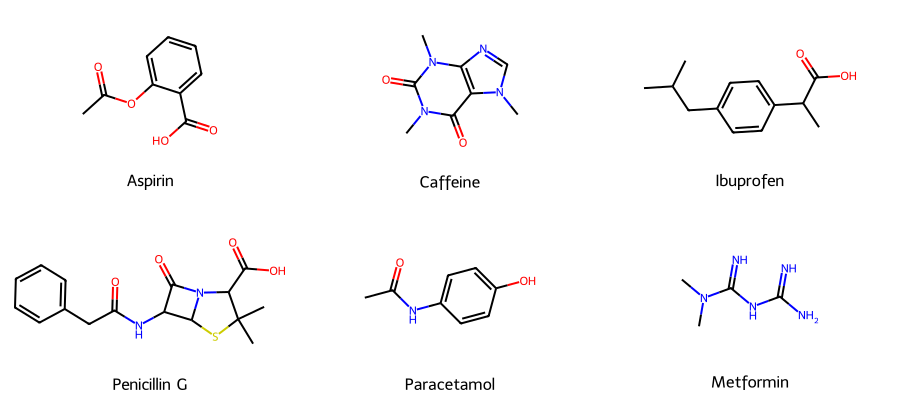

In [20]:
visualize_molecules(molecules_df)

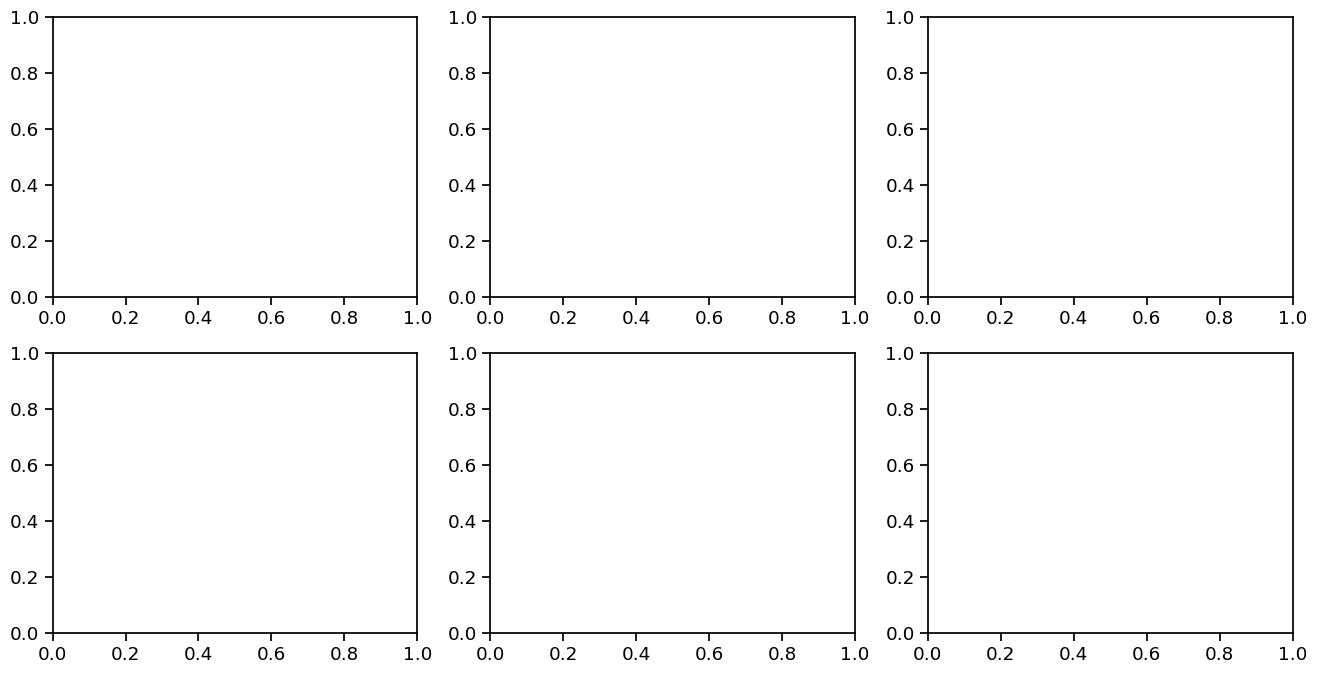

In [21]:
# Explore property distributions
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs = axs.flatten()

In [22]:
properties = ['MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors', 'NumRotBonds']

In [23]:
for i, prop in enumerate(properties):
    sns.histplot(molecules_df[prop], kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {prop}')
    axs[i].set_xlabel(prop)

In [24]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

## 5. String-Based Representations

String-based representations encode molecules as text strings, providing a compact and human-readable format.

In [25]:
# @title SMILES and Alternative String Representations { display-mode: "form" }
def generate_string_representations(smiles_list):
    """Generate different string representations for molecules."""
    
    from rdkit.Chem import inchi
    
    results = []
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Generate standard SMILES
            canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
            
            # Generate non-isomeric SMILES (without stereochemistry)
            nonisomeric_smiles = Chem.MolToSmiles(mol, isomericSmiles=False)
            
            # Generate InChI and InChIKey
            inchi_str = inchi.MolToInchi(mol)
            inchikey = inchi.InchiToInchiKey(inchi_str)
            
            results.append({
                'Original SMILES': smiles,
                'Canonical SMILES': canonical_smiles,
                'Non-isomeric SMILES': nonisomeric_smiles,
                'InChI': inchi_str,
                'InChIKey': inchikey
            })
    
    return pd.DataFrame(results)

In [26]:
# Generate string representations for the first 5 molecules
string_df = generate_string_representations(molecules_df['SMILES'][:5])

[14:53:26] WARNING: Omitted undefined stereo

[14:53:26] WARNING: Omitted undefined stereo



In [27]:
# Display the results
print("Different string representations for the same molecules:")
pd.set_option('display.max_colwidth', 80)  # For better display
display(string_df)

Different string representations for the same molecules:


,Original SMILES,Canonical SMILES,Non-isomeric SMILES,InChI,InChIKey
0,CC(=O)OC1=CC=CC=C1C(=O)O,CC(=O)Oc1ccccc1C(=O)O,CC(=O)Oc1ccccc1C(=O)O,"InChI=1S/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)12/h2-5H,1H3,(H,11,12)",BSYNRYMUTXBXSQ-UHFFFAOYSA-N
1,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,Cn1c(=O)c2c(ncn2C)n(C)c1=O,Cn1c(=O)c2c(ncn2C)n(C)c1=O,"InChI=1S/C8H10N4O2/c1-10-4-9-6-5(10)7(13)12(3)8(14)11(6)2/h4H,1-3H3",RYYVLZVUVIJVGH-UHFFFAOYSA-N
2,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,CC(C)Cc1ccc(C(C)C(=O)O)cc1,CC(C)Cc1ccc(C(C)C(=O)O)cc1,"InChI=1S/C13H18O2/c1-9(2)8-11-4-6-12(7-5-11)10(3)13(14)15/h4-7,9-10H,8H2,1-3...",HEFNNWSXXWATRW-UHFFFAOYSA-N
3,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,CC1(C)SC2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O,CC1(C)SC2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O,InChI=1S/C16H18N2O4S/c1-16(2)12(15(21)22)18-13(20)11(14(18)23-16)17-10(19)8-...,JGSARLDLIJGVTE-UHFFFAOYSA-N
4,CC(=O)NC1=CC=C(C=C1)O,CC(=O)Nc1ccc(O)cc1,CC(=O)Nc1ccc(O)cc1,"InChI=1S/C8H9NO2/c1-6(10)9-7-2-4-8(11)5-3-7/h2-5,11H,1H3,(H,9,10)",RZVAJINKPMORJF-UHFFFAOYSA-N


### 5.1 Properties of SMILES Representation

In [28]:
# Demonstrate uniqueness issue with SMILES
def demonstrate_smiles_properties():
    # Create a molecule with multiple valid SMILES
    mol = Chem.MolFromSmiles('c1ccccc1')  # Benzene
    
    # Generate some different SMILES for the same molecule
    smiles1 = Chem.MolToSmiles(mol)
    
    # Create the same molecule a different way
    mol2 = Chem.MolFromSmiles('C1=CC=CC=C1')  # Also benzene
    smiles2 = Chem.MolToSmiles(mol2)
    
    # Create benzene with explicit hydrogens
    mol3 = Chem.AddHs(mol)
    smiles3 = Chem.MolToSmiles(mol3)
    
    # Demonstrate invariance issue
    atoms = list(range(mol.GetNumAtoms()))
    np.random.shuffle(atoms)
    mol4 = Chem.RenumberAtoms(mol, atoms)
    smiles4 = Chem.MolToSmiles(mol4, canonical=False)  # Non-canonical
    smiles4_canonical = Chem.MolToSmiles(mol4)  # Canonical (should match smiles1)
    
    # Display results
    results = pd.DataFrame({
        'Representation': ['Standard SMILES', 'Alternative SMILES', 'SMILES with hydrogens', 
                         'Non-canonical SMILES', 'Canonical SMILES'],
        'String': [smiles1, smiles2, smiles3, smiles4, smiles4_canonical],
        'Notes': [
            'Default representation', 
            'Using Kekulé structure',
            'With explicit hydrogens',
            'After atom reordering (non-canonical)',
            'After atom reordering (canonical)'
        ]
    })
    
    display(results)
    
    print("\nObservations:")
    print("1. The same molecule can have multiple SMILES representations")
    print("2. Canonical SMILES addresses the invariance issue by providing a unique representation")
    print("3. SMILES can represent the same molecule with different levels of detail")

In [29]:
demonstrate_smiles_properties()

,Representation,String,Notes
0,Standard SMILES,c1ccccc1,Default representation
1,Alternative SMILES,c1ccccc1,Using Kekulé structure
2,SMILES with hydrogens,[H]c1c([H])c([H])c([H])c([H])c1[H],With explicit hydrogens
3,Non-canonical SMILES,c1ccccc1,After atom reordering (non-canonical)
4,Canonical SMILES,c1ccccc1,After atom reordering (canonical)



Observations:
1. The same molecule can have multiple SMILES representations
2. Canonical SMILES addresses the invariance issue by providing a unique representation
3. SMILES can represent the same molecule with different levels of detail


## 6. Fingerprint-Based Representations

Molecular fingerprints are bit vectors or count vectors that encode the presence or frequency of specific structural features in a molecule.

In [30]:
# @title Generate Different Types of Fingerprints { display-mode: "form" }
def generate_fingerprints(mol, fp_type='morgan', radius=2, nBits=2048):
    """Generate different types of molecular fingerprints."""
    
    if mol is None:
        return None
    
    if fp_type == 'morgan':
        # Morgan fingerprints (ECFP-like)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    elif fp_type == 'maccs':
        # MACCS keys (166 bits)
        fp = MACCSkeys.GenMACCSKeys(mol)
    elif fp_type == 'rdkit':
        # RDKit topological fingerprint
        fp = FingerprintMols.FingerprintMol(mol)
    elif fp_type == 'atom_pair':
        # Atom pair fingerprints
        fp = Pairs.GetAtomPairFingerprint(mol)
    elif fp_type == 'torsion':
        # Topological torsion fingerprints
        fp = Torsions.GetTopologicalTorsionFingerprint(mol)
    else:
        raise ValueError(f"Fingerprint type '{fp_type}' not supported")
    
    # Convert to NumPy array
    array = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, array)
    
    return array

In [31]:
# Generate fingerprints for each molecule in the dataset
def calculate_all_fingerprints(dataframe):
    """Calculate different types of fingerprints for all molecules in the dataset."""
    
    # Dictionary to store results
    fingerprints = {
        'morgan': [],
        'maccs': [],
        'rdkit': [],
        'atom_pair': [],
        'torsion': []
    }
    
    # Calculate fingerprints for each molecule
    for mol in tqdm(dataframe['Molecule'], desc="Calculating fingerprints"):
        fingerprints['morgan'].append(generate_fingerprints(mol, 'morgan'))
        fingerprints['maccs'].append(generate_fingerprints(mol, 'maccs'))
        fingerprints['rdkit'].append(generate_fingerprints(mol, 'rdkit'))
        fingerprints['atom_pair'].append(generate_fingerprints(mol, 'atom_pair'))
        fingerprints['torsion'].append(generate_fingerprints(mol, 'torsion'))
    
    return fingerprints

In [ ]:
# Calculate fingerprints
fingerprints = calculate_all_fingerprints(molecules_df)

Calculating fingerprints:   0%|          | 0/20 [00:00<?, ?it/s]

### 6.1 Visualizing Fingerprints

In [ ]:
# @title Fingerprint Visualization { display-mode: "form" }
def visualize_fingerprint(fp, title="Molecular Fingerprint", n_bits=None):
    """Visualize a molecular fingerprint as a binary pattern."""
    if n_bits is None:
        n_bits = len(fp)
    
    # Limit to first n_bits for visualization
    fp_subset = fp[:n_bits]
    
    # Reshape to a more visual format
    if n_bits > 100:
        # Calculate dimensions for a roughly square layout
        width = int(np.ceil(np.sqrt(n_bits)))
        height = int(np.ceil(n_bits / width))
        
        # Pad the fingerprint to fit the grid
        padded_fp = np.zeros(width * height)
        padded_fp[:n_bits] = fp_subset
        
        # Reshape to grid
        fp_grid = padded_fp.reshape(height, width)
    else:
        # For small fingerprints, just display as is
        fp_grid = fp_subset.reshape(1, -1)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(fp_grid, cmap='binary', interpolation='nearest')
    plt.title(title)
    plt.colorbar(label='Bit value')
    plt.tight_layout()
    plt.show()
    
    # Print fingerprint statistics
    total_bits = len(fp)
    active_bits = np.sum(fp > 0)
    print(f"Fingerprint statistics:")
    print(f"Total bits: {total_bits}")
    print(f"Active bits: {active_bits} ({active_bits/total_bits:.2%})")

In [ ]:
# Let's visualize fingerprints for a sample molecule (Aspirin)
aspirin_idx = molecules_df[molecules_df['Name'] == 'Aspirin'].index[0]

In [ ]:
# Visualize different fingerprints for Aspirin
print("Morgan (ECFP) Fingerprint for Aspirin:")
visualize_fingerprint(fingerprints['morgan'][aspirin_idx], 
                     "Morgan Fingerprint (ECFP4) for Aspirin", n_bits=256)

In [ ]:
print("\nMACCS Keys for Aspirin:")
visualize_fingerprint(fingerprints['maccs'][aspirin_idx], 
                     "MACCS Keys for Aspirin")

In [ ]:
print("\nRDKit Topological Fingerprint for Aspirin:")
visualize_fingerprint(fingerprints['rdkit'][aspirin_idx], 
                     "RDKit Topological Fingerprint for Aspirin", n_bits=256)

### 6.2 Fingerprint Similarity

In [ ]:
def calculate_similarity_matrix(fingerprints, method='tanimoto'):
    """
    Calculate similarity matrix between molecules based on fingerprints.
    
    Parameters:
    -----------
    fingerprints : list
        List of fingerprints for all molecules
    method : str
        Similarity metric ('tanimoto', 'dice', 'cosine')
        
    Returns:
    --------
    numpy.ndarray
        Similarity matrix
    """
    n_mols = len(fingerprints)
    similarity_matrix = np.zeros((n_mols, n_mols))
    
    for i in range(n_mols):
        for j in range(i, n_mols):
            # Different similarity metrics
            if method == 'tanimoto':
                sim = DataStructs.TanimotoSimilarity(
                    DataStructs.cDataStructs.CreateFromBitString(''.join(str(int(b)) for b in fingerprints[i])),
                    DataStructs.cDataStructs.CreateFromBitString(''.join(str(int(b)) for b in fingerprints[j]))
                )
            elif method == 'dice':
                sim = DataStructs.DiceSimilarity(
                    DataStructs.cDataStructs.CreateFromBitString(''.join(str(int(b)) for b in fingerprints[i])),
                    DataStructs.cDataStructs.CreateFromBitString(''.join(str(int(b)) for b in fingerprints[j]))
                )
            elif method == 'cosine':
                sim = cosine_similarity([fingerprints[i]], [fingerprints[j]])[0, 0]
            
            # Fill both sides of the symmetric matrix
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim
    
    return similarity_matrix

In [ ]:
# Calculate Tanimoto similarity for Morgan fingerprints
morgan_similarity = calculate_similarity_matrix(fingerprints['morgan'], method='tanimoto')

In [ ]:
# Visualize the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(morgan_similarity, cmap='viridis', xticklabels=molecules_df['Name'], 
           yticklabels=molecules_df['Name'], annot=False)
plt.title('Molecular Similarity (Morgan Fingerprints with Tanimoto)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 7. Descriptor-Based Representations

Molecular descriptors are numerical values that characterize various physical, chemical, and structural properties of molecules.

In [ ]:
# @title Calculate Molecular Descriptors { display-mode: "form" }
def calculate_descriptors(mol):
    """Calculate a comprehensive set of RDKit descriptors for a molecule."""
    
    if mol is None:
        return None
    
    # List of descriptor functions to calculate
    descriptor_functions = [
        # Physical properties
        (Descriptors.MolWt, "Molecular Weight"),
        (Descriptors.ExactMolWt, "Exact Molecular Weight"),
        (Descriptors.HeavyAtomMolWt, "Heavy Atom Molecular Weight"),
        (Descriptors.MolLogP, "LogP"),
        (Descriptors.MolMR, "Molar Refractivity"),
        (Descriptors.TPSA, "Topological Polar Surface Area"),
        
        # Atom counts and fractions
        (Descriptors.HeavyAtomCount, "Heavy Atom Count"),
        (Descriptors.NumValenceElectrons, "Valence Electron Count"),
        (Descriptors.NumHDonors, "H-Bond Donors"),
        (Descriptors.NumHAcceptors, "H-Bond Acceptors"),
        (Descriptors.NHOHCount, "NHOH Count"),
        (Descriptors.NOCount, "NO Count"),
        (Descriptors.NumRotatableBonds, "Rotatable Bonds"),
        (Descriptors.NumHeteroatoms, "Heteroatom Count"),
        (Descriptors.FractionCSP3, "Fraction of SP3 Carbon"),
        
        # Topological descriptors
        (Descriptors.BalabanJ, "Balaban's J Index"),
        (Descriptors.BertzCT, "Bertz CT"),
        (Descriptors.Chi0v, "Atomic Connectivity Index (order 0)"),
        (Descriptors.Chi1v, "Atomic Connectivity Index (order 1)"),
        (Descriptors.Chi2v, "Atomic Connectivity Index (order 2)"),
        (Descriptors.Chi3v, "Atomic Connectivity Index (order 3)"),
        (Descriptors.Chi4v, "Atomic Connectivity Index (order 4)"),
        (Descriptors.HallKierAlpha, "Hall-Kier Alpha"),
        
        # Ring descriptors
        (Descriptors.NumAromaticRings, "Aromatic Ring Count"),
        (Descriptors.NumSaturatedRings, "Saturated Ring Count"),
        (Descriptors.NumAliphaticRings, "Aliphatic Ring Count"),
        (Descriptors.NumAromaticHeterocycles, "Aromatic Heterocycle Count"),
        (Descriptors.NumSaturatedHeterocycles, "Saturated Heterocycle Count"),
        (Descriptors.NumAliphaticHeterocycles, "Aliphatic Heterocycle Count"),
        (Descriptors.NumAromaticCarbocycles, "Aromatic Carbocycle Count"),
        (Descriptors.NumSaturatedCarbocycles, "Saturated Carbocycle Count"),
        (Descriptors.NumAliphaticCarbocycles, "Aliphatic Carbocycle Count"),
        
        # Other descriptors
        (Descriptors.LabuteASA, "Labute ASA"),
        (Descriptors.Kappa1, "Kappa 1"),
        (Descriptors.Kappa2, "Kappa 2"),
        (Descriptors.Kappa3, "Kappa 3")
    ]
    
    # Calculate descriptors
    descriptors = {}
    for func, name in descriptor_functions:
        try:
            value = func(mol)
            descriptors[name] = value
        except:
            descriptors[name] = None
    
    return descriptors

In [ ]:
# Calculate descriptors for all molecules
def calculate_all_descriptors(dataframe):
    """Calculate descriptors for all molecules in the dataset."""
    
    all_descriptors = []
    
    for mol in tqdm(dataframe['Molecule'], desc="Calculating descriptors"):
        desc = calculate_descriptors(mol)
        all_descriptors.append(desc)
    
    # Convert to DataFrame
    desc_df = pd.DataFrame(all_descriptors)
    
    return desc_df

In [ ]:
# Calculate descriptors
descriptors_df = calculate_all_descriptors(molecules_df)

In [ ]:
# Add molecule names for reference
descriptors_df['Name'] = molecules_df['Name']

In [ ]:
# Display a sample of the descriptors
print(f"Total descriptors calculated: {descriptors_df.shape[1] - 1}")  # minus Name column
display(descriptors_df.head(5))

### 7.1 Analyzing Molecular Descriptors

In [ ]:
# @title Descriptor Analysis and Correlation { display-mode: "form" }
def analyze_descriptors(desc_df):
    """Analyze descriptor values and relationships."""
    
    # Remove non-numeric columns
    numeric_df = desc_df.select_dtypes(include=[np.number])
    
    # Calculate basic statistics
    desc_stats = numeric_df.describe().T
    desc_stats['Variance'] = numeric_df.var()
    desc_stats['Missing'] = numeric_df.isnull().sum()
    
    # Sort by variance (for feature importance)
    desc_stats = desc_stats.sort_values('Variance', ascending=False)
    
    # Display the most variable descriptors
    print("Descriptors with highest variance:")
    display(desc_stats.head(10))
    
    # Calculate correlation matrix
    corr_matrix = numeric_df.corr()
    
    # Visualize correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5, annot=False)
    plt.title('Correlation Matrix of Molecular Descriptors')
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated pairs
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr = corr_matrix.iloc[i, j]
            if abs(corr) > 0.9:  # Threshold for high correlation
                corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr))
    
    # Display highly correlated pairs
    if corr_pairs:
        print("\nHighly correlated descriptor pairs (|r| > 0.9):")
        for desc1, desc2, corr in sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"{desc1} ~ {desc2}: r = {corr:.3f}")
    else:
        print("\nNo highly correlated descriptor pairs found.")
    
    return desc_stats

In [ ]:
# Analyze descriptors
desc_stats = analyze_descriptors(descriptors_df)

### 7.2 Dimensionality Reduction for Descriptors

In [ ]:
# @title PCA on Molecular Descriptors { display-mode: "form" }
def perform_pca_on_descriptors(desc_df, n_components=2):
    """Perform PCA on molecular descriptors and visualize results."""
    
    # Prepare data for PCA
    # Remove non-numeric columns and handle missing values
    numeric_df = desc_df.select_dtypes(include=[np.number])
    numeric_df = numeric_df.fillna(numeric_df.mean())
    
    # Standardize the data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df)
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_data)
    
    # Create DataFrame with PCA results
    pca_df = pd.DataFrame(
        data=pca_result,
        columns=[f'PC{i+1}' for i in range(n_components)]
    )
    pca_df['Name'] = desc_df['Name']
    
    # Visualize PCA results
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.8, s=100)
    
    # Add labels for each point
    for i, txt in enumerate(pca_df['Name']):
        plt.annotate(txt, (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), fontsize=9,
                   xytext=(5, 5), textcoords='offset points')
    
    # Add explained variance information
    explained_var = pca.explained_variance_ratio_
    plt.xlabel(f'PC1 ({explained_var[0]:.2%} explained variance)')
    plt.ylabel(f'PC2 ({explained_var[1]:.2%} explained variance)')
    plt.title('PCA of Molecular Descriptors')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Get feature importance
    components = pd.DataFrame(
        data=pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=numeric_df.columns
    )
    
    # Display the most important features for each component
    print("Top descriptors contributing to principal components:")
    for i in range(n_components):
        pc = f'PC{i+1}'
        top_features = components[pc].abs().sort_values(ascending=False).head(5)
        print(f"\n{pc} (explains {explained_var[i]:.2%} of variance):")
        for j, (feature, importance) in enumerate(top_features.items(), 1):
            print(f"  {j}. {feature}: {importance:.3f}")
    
    return pca_df, components

In [ ]:
# Perform PCA
pca_df, pca_components = perform_pca_on_descriptors(descriptors_df)

## 8. Graph-Based Representations

Graph-based representations treat molecules as graphs, with atoms as nodes and bonds as edges. This preserves the full topological structure of the molecule.

In [ ]:
# @title Molecule to Graph Conversion { display-mode: "form" }
def mol_to_graph(mol):
    """Convert an RDKit molecule to a graph representation (adjacency matrix and feature matrices)."""
    
    if mol is None:
        return None
    
    # Get number of atoms
    n_atoms = mol.GetNumAtoms()
    
    # Initialize adjacency matrix
    adjacency_matrix = np.zeros((n_atoms, n_atoms))
    
    # Fill adjacency matrix with bond information
    for bond in mol.GetBonds():
        start_atom = bond.GetBeginAtomIdx()
        end_atom = bond.GetEndAtomIdx()
        bond_type = bond.GetBondTypeAsDouble()
        
        # Set bond in both directions (undirected graph)
        adjacency_matrix[start_atom, end_atom] = bond_type
        adjacency_matrix[end_atom, start_atom] = bond_type
    
    # Create node feature matrix
    node_features = []
    
    for atom in mol.GetAtoms():
        # Basic atomic features
        features = [
            atom.GetAtomicNum(),         # Atomic number
            atom.GetTotalDegree(),       # Total degree (number of bonds)
            atom.GetFormalCharge(),      # Formal charge
            atom.GetTotalNumHs(),        # Total number of Hydrogens
            int(atom.GetIsAromatic()),   # Aromaticity flag
            atom.GetMass(),              # Atomic mass
            atom.GetImplicitValence()    # Implicit valence
        ]
        
        node_features.append(features)
    
    return {
        'adjacency_matrix': adjacency_matrix,
        'node_features': np.array(node_features)
    }

In [ ]:
# Convert a sample molecule to graph representation
def visualize_molecule_graph(mol_name):
    """Visualize a molecule as a graph."""
    
    # Get the molecule
    mol_idx = molecules_df[molecules_df['Name'] == mol_name].index[0]
    mol = molecules_df.loc[mol_idx, 'Molecule']
    
    # Convert to graph
    graph = mol_to_graph(mol)
    
    if graph is None:
        print(f"Could not convert {mol_name} to graph representation.")
        return
    
    # Display the molecule
    print(f"Molecule: {mol_name}")
    display(Draw.MolToImage(mol, size=(300, 200)))
    
    # Display adjacency matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(graph['adjacency_matrix'], cmap='viridis')
    plt.colorbar(label='Bond Type')
    plt.title(f'Adjacency Matrix for {mol_name}')
    plt.tight_layout()
    plt.show()
    
    # Display node features
    node_df = pd.DataFrame(
        graph['node_features'],
        columns=['Atomic Number', 'Degree', 'Formal Charge', 'Num Hs', 'Is Aromatic', 'Mass', 'Implicit Valence']
    )
    
    print(f"\nNode features for {mol_name}:")
    display(node_df)
    
    # Create a network visualization of the molecule
    import networkx as nx
    
    G = nx.from_numpy_array(graph['adjacency_matrix'])
    
    # Get atom symbols for labels
    atom_labels = {}
    for i, atom in enumerate(mol.GetAtoms()):
        atom_labels[i] = atom.GetSymbol()
    
    # Get node colors based on atom type
    atom_colors = []
    for atom in mol.GetAtoms():
        # Simple color scheme
        if atom.GetSymbol() == 'C':
            atom_colors.append('grey')
        elif atom.GetSymbol() == 'O':
            atom_colors.append('red')
        elif atom.GetSymbol() == 'N':
            atom_colors.append('blue')
        elif atom.GetSymbol() == 'S':
            atom_colors.append('yellow')
        elif atom.GetSymbol() == 'F' or atom.GetSymbol() == 'Cl' or atom.GetSymbol() == 'Br':
            atom_colors.append('green')
        else:
            atom_colors.append('purple')
    
    # Draw the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)  # For reproducible layout
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=atom_colors, node_size=500)
    
    # Get edge weights (bond types) for drawing
    edge_weights = nx.get_edge_attributes(G, 'weight').items()
    
    # Draw edges with different styles based on bond type
    single_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] == 1.0]
    double_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] == 2.0]
    triple_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] == 3.0]
    aromatic_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] == 1.5]
    
    nx.draw_networkx_edges(G, pos, edgelist=single_edges, width=1.5)
    nx.draw_networkx_edges(G, pos, edgelist=double_edges, width=2.5)
    nx.draw_networkx_edges(G, pos, edgelist=triple_edges, width=3.5)
    nx.draw_networkx_edges(G, pos, edgelist=aromatic_edges, width=1.5, style='dashed')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, atom_labels)
    
    plt.title(f'Graph Representation of {mol_name}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize graph representations of a few molecules
visualize_molecule_graph('Aspirin')
visualize_molecule_graph('Paracetamol')

## 9. 3D Representations

3D representations capture the three-dimensional structure of molecules, which is often crucial for understanding biological activity.

In [ ]:
# @title Generate and Visualize 3D Structures { display-mode: "form" }
def generate_3d_conformer(mol, optimize=True):
    """Generate a 3D conformer for a molecule."""
    
    if mol is None:
        return None
    
    # Create a copy of the molecule
    mol_3d = Chem.Mol(mol)
    
    # Add hydrogens
    mol_3d = Chem.AddHs(mol_3d)
    
    # Generate 3D coordinates
    try:
        AllChem.EmbedMolecule(mol_3d, randomSeed=42)
        
        # Energy minimize with MMFF
        if optimize:
            AllChem.MMFFOptimizeMolecule(mol_3d)
        
        return mol_3d
    except:
        print(f"Could not generate 3D conformer.")
        return None

In [ ]:
# Generate 3D conformers for visualization
def visualize_3d_molecule(mol_name):
    """Generate and visualize a 3D structure for a molecule."""
    
    # Get the molecule
    mol_idx = molecules_df[molecules_df['Name'] == mol_name].index[0]
    mol = molecules_df.loc[mol_idx, 'Molecule']
    
    # Generate 3D conformer
    mol_3d = generate_3d_conformer(mol)
    
    if mol_3d is None:
        print(f"Could not generate 3D conformer for {mol_name}.")
        return
    
    # Get atomic coordinates
    conf = mol_3d.GetConformer()
    coords = np.array([conf.GetAtomPosition(i) for i in range(mol_3d.GetNumAtoms())])
    
    # Get atom symbols
    atom_symbols = [atom.GetSymbol() for atom in mol_3d.GetAtoms()]
    
    # Create a map of atom symbols to colors
    atom_colors = {
        'C': 'grey',
        'O': 'red',
        'N': 'blue',
        'S': 'yellow',
        'F': 'green',
        'Cl': 'green',
        'Br': 'brown',
        'I': 'purple',
        'H': 'white'
    }
    
    # Get colors for each atom
    colors = [atom_colors.get(symbol, 'pink') for symbol in atom_symbols]
    
    # Display the 2D structure for reference
    print(f"Molecule: {mol_name}")
    display(Draw.MolToImage(mol, size=(300, 200)))
    
    # Create 3D visualization
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot atoms
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=colors, s=100)
    
    # Plot bonds
    for bond in mol_3d.GetBonds():
        idx1 = bond.GetBeginAtomIdx()
        idx2 = bond.GetEndAtomIdx()
        
        # Get coordinates
        pos1 = coords[idx1]
        pos2 = coords[idx2]
        
        # Plot the bond
        ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]], 'k-', alpha=0.6)
    
    # Customize the plot
    ax.set_title(f'3D Structure of {mol_name}')
    
    # Set axis labels and limits
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Set equal aspect ratio
    max_range = np.array([coords[:, 0].max() - coords[:, 0].min(),
                         coords[:, 1].max() - coords[:, 1].min(),
                         coords[:, 2].max() - coords[:, 2].min()]).max() / 2.0
    
    mid_x = (coords[:, 0].max() + coords[:, 0].min()) / 2.0
    mid_y = (coords[:, 1].max() + coords[:, 1].min()) / 2.0
    mid_z = (coords[:, 2].max() + coords[:, 2].min()) / 2.0
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.tight_layout()
    plt.show()
    
    # Display the 3D distance matrix
    print(f"\n3D Distance Matrix for {mol_name}:")
    
    # Calculate distance matrix
    n_atoms = mol_3d.GetNumAtoms()
    distance_matrix = np.zeros((n_atoms, n_atoms))
    
    for i in range(n_atoms):
        for j in range(i+1, n_atoms):
            # Calculate Euclidean distance
            pos_i = np.array(conf.GetAtomPosition(i))
            pos_j = np.array(conf.GetAtomPosition(j))
            dist = np.linalg.norm(pos_i - pos_j)
            
            # Store distance in the matrix
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
    
    # Create a more readable version of the matrix for display
    atom_indices = [f"{atom.GetSymbol()}{i}" for i, atom in enumerate(mol_3d.GetAtoms())]
    distance_df = pd.DataFrame(distance_matrix, index=atom_indices, columns=atom_indices)
    
    # Display a subset for readability (non-hydrogen atoms only)
    non_h_indices = [idx for idx, symbol in enumerate(atom_symbols) if symbol != 'H']
    non_h_labels = [atom_indices[i] for i in non_h_indices]
    
    display(distance_df.loc[non_h_labels, non_h_labels].round(2))

In [ ]:
# Visualize 3D structure of a molecule
visualize_3d_molecule('Aspirin')

## 10. Similarity and Kernels for Molecules

Kernels and similarity measures are essential for many machine learning methods, especially for Bayesian optimization. Here we'll explore different similarity metrics for molecules.

In [ ]:
# @title Molecular Similarity Calculation { display-mode: "form" }
def calculate_multiple_similarities(mol1, mol2):
    """Calculate different similarity metrics between two molecules."""
    
    if mol1 is None or mol2 is None:
        return None
    
    # Generate different fingerprints
    fp1_morgan = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, nBits=2048)
    fp2_morgan = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, nBits=2048)
    
    fp1_maccs = MACCSkeys.GenMACCSKeys(mol1)
    fp2_maccs = MACCSkeys.GenMACCSKeys(mol2)
    
    fp1_rdkit = FingerprintMols.FingerprintMol(mol1)
    fp2_rdkit = FingerprintMols.FingerprintMol(mol2)
    
    # Calculate similarities
    tanimoto_morgan = DataStructs.TanimotoSimilarity(fp1_morgan, fp2_morgan)
    tanimoto_maccs = DataStructs.TanimotoSimilarity(fp1_maccs, fp2_maccs)
    tanimoto_rdkit = DataStructs.TanimotoSimilarity(fp1_rdkit, fp2_rdkit)
    
    dice_morgan = DataStructs.DiceSimilarity(fp1_morgan, fp2_morgan)
    cosine_morgan = DataStructs.CosineSimilarity(fp1_morgan, fp2_morgan)
    
    # Molecular descriptor similarity
    desc1 = calculate_descriptors(mol1)
    desc2 = calculate_descriptors(mol2)
    
    # Convert descriptors to vector (only numeric values)
    desc_vector1 = np.array([v for k, v in desc1.items() if isinstance(v, (int, float)) and v is not None])
    desc_vector2 = np.array([v for k, v in desc2.items() if isinstance(v, (int, float)) and v is not None])
    
    # Ensure vectors are the same length (use min length)
    min_len = min(len(desc_vector1), len(desc_vector2))
    desc_vector1 = desc_vector1[:min_len]
    desc_vector2 = desc_vector2[:min_len]
    
    # Calculate Euclidean distance
    euclidean_desc = np.linalg.norm(desc_vector1 - desc_vector2)
    
    # Normalize to similarity score (1 for identical, 0 for very different)
    # Using a simple exponential transformation
    desc_similarity = np.exp(-euclidean_desc / 100)
    
    return {
        'Tanimoto (Morgan)': tanimoto_morgan,
        'Tanimoto (MACCS)': tanimoto_maccs,
        'Tanimoto (RDKit)': tanimoto_rdkit,
        'Dice (Morgan)': dice_morgan,
        'Cosine (Morgan)': cosine_morgan,
        'Descriptor Similarity': desc_similarity
    }

In [ ]:
# Compare some molecules
def compare_molecules(name1, name2):
    """Compare two molecules using different similarity metrics."""
    
    # Get the molecules
    mol1_idx = molecules_df[molecules_df['Name'] == name1].index[0]
    mol2_idx = molecules_df[molecules_df['Name'] == name2].index[0]
    
    mol1 = molecules_df.loc[mol1_idx, 'Molecule']
    mol2 = molecules_df.loc[mol2_idx, 'Molecule']
    
    # Calculate similarities
    similarities = calculate_multiple_similarities(mol1, mol2)
    
    if similarities is None:
        print(f"Could not calculate similarities between {name1} and {name2}.")
        return
    
    # Display the molecules
    print(f"Comparing {name1} and {name2}:")
    
    # Create a side-by-side visualization
    img = Draw.MolsToGridImage([mol1, mol2], molsPerRow=2, 
                              subImgSize=(300, 200),
                              legends=[name1, name2])
    display(img)
    
    # Display similarity scores
    sim_df = pd.DataFrame({
        'Similarity Metric': list(similarities.keys()),
        'Score': list(similarities.values())
    })
    
    # Sort by score
    sim_df = sim_df.sort_values('Score', ascending=False)
    
    # Display as bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Score', y='Similarity Metric', data=sim_df)
    plt.title(f'Similarity Metrics: {name1} vs {name2}')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

In [ ]:
# Compare some pair of molecules
compare_molecules('Aspirin', 'Ibuprofen')
compare_molecules('Aspirin', 'Paracetamol')

### 10.1 Kernel Functions for Molecular Machine Learning

In [ ]:
# @title Implement Molecular Kernels { display-mode: "form" }
def tanimoto_kernel(fp1, fp2):
    """
    Tanimoto kernel function for bit vectors.
    
    Parameters:
    -----------
    fp1, fp2 : numpy arrays
        Fingerprint bit vectors
        
    Returns:
    --------
    float
        Tanimoto similarity
    """
    intersection = np.sum(np.logical_and(fp1, fp2))
    union = np.sum(np.logical_or(fp1, fp2))
    
    if union == 0:
        return 0.0
    
    return intersection / union

In [ ]:
def gaussian_kernel(x1, x2, sigma=1.0):
    """
    Gaussian (RBF) kernel for molecular descriptors.
    
    Parameters:
    -----------
    x1, x2 : numpy arrays
        Feature vectors
    sigma : float
        Kernel width parameter
        
    Returns:
    --------
    float
        Gaussian kernel value
    """
    return np.exp(-np.sum((x1 - x2)**2) / (2 * sigma**2))

In [ ]:
def minmax_kernel(fp1, fp2):
    """
    MinMax kernel for bit vectors (fingerprints).
    
    Parameters:
    -----------
    fp1, fp2 : numpy arrays
        Fingerprint bit vectors
        
    Returns:
    --------
    float
        MinMax kernel value
    """
    intersection = np.sum(np.logical_and(fp1, fp2))
    sum_min = np.sum(np.minimum(fp1, fp2))
    sum_max = np.sum(np.maximum(fp1, fp2))
    
    if sum_max == 0:
        return 0.0
    
    return intersection / sum_max

In [ ]:
# Demonstrate kernels on molecular data
def visualize_kernel_matrix(kernel_func, data, labels):
    """
    Visualize a kernel matrix for a set of molecules.
    
    Parameters:
    -----------
    kernel_func : function
        Kernel function to compute similarity
    data : list of numpy arrays
        List of fingerprints or feature vectors
    labels : list of str
        List of molecule names
        
    Returns:
    --------
    numpy.ndarray
        Kernel matrix
    """
    n = len(data)
    K = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            K[i, j] = kernel_func(data[i], data[j])
    
    # Visualize the kernel matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(K, annot=False, cmap='viridis', xticklabels=labels, yticklabels=labels)
    plt.title('Kernel Matrix')
    plt.tight_layout()
    plt.show()
    
    return K

In [ ]:
# Get Morgan fingerprints for kernel demonstration
morgan_fps = [fp for fp in fingerprints['morgan']]
mol_names = molecules_df['Name'].tolist()

In [ ]:
# Select a subset for better visualization
subset_size = 10
subset_indices = np.random.choice(len(morgan_fps), subset_size, replace=False)
subset_fps = [morgan_fps[i] for i in subset_indices]
subset_names = [mol_names[i] for i in subset_indices]

In [ ]:
# Visualize Tanimoto kernel matrix
print("Tanimoto Kernel Matrix:")
tanimoto_matrix = visualize_kernel_matrix(tanimoto_kernel, subset_fps, subset_names)

In [ ]:
# Get descriptor vectors for Gaussian kernel
# Using a subset of descriptors for simplicity
desc_vectors = []
selected_descs = ['Molecular Weight', 'LogP', 'Topological Polar Surface Area', 
                 'H-Bond Donors', 'H-Bond Acceptors', 'Rotatable Bonds']

In [ ]:
for i in subset_indices:
    desc = [descriptors_df.iloc[i][desc] for desc in selected_descs]
    desc_vectors.append(np.array(desc))

In [ ]:
# Normalize descriptors
desc_array = np.array(desc_vectors)
desc_mean = np.mean(desc_array, axis=0)
desc_std = np.std(desc_array, axis=0)
desc_norm = (desc_array - desc_mean) / desc_std

In [ ]:
print("\nGaussian Kernel Matrix (on molecular descriptors):")
gaussian_matrix = visualize_kernel_matrix(
    lambda x, y: gaussian_kernel(x, y, sigma=1.0), 
    desc_norm, 
    subset_names
)

## 11. Choosing the Right Representation

The choice of molecular representation depends on the specific task, available data, computational resources, and the machine learning method being used.

In [ ]:
# @title Representation Selection Guide { display-mode: "form" }
# Create a decision tree-like guide for representation selection
def show_representation_guide():
    """Display a guide for selecting appropriate molecular representations."""
    
    html = """
    <div style="background-color:#f8f9fa; padding:20px; border-radius:10px; line-height:1.5;">
    <h3 style="text-align:center;">Guide for Selecting Molecular Representations</h3>
    
    <h4>Based on Machine Learning Task:</h4>
    <ul>
        <li><strong>Property prediction (regression/classification):</strong>
            <ul>
                <li>Fingerprints (Morgan/ECFP) for general purpose</li>
                <li>Descriptors when interpretability is important</li>
                <li>Graph representations for deep learning methods</li>
            </ul>
        </li>
        <li><strong>Virtual screening/similarity search:</strong>
            <ul>
                <li>Fingerprints (Morgan/ECFP, MACCS) for speed and effectiveness</li>
                <li>Pharmacophore features when binding information is available</li>
            </ul>
        </li>
        <li><strong>De novo molecule design:</strong>
            <ul>
                <li>SMILES or graph representations for generative models</li>
                <li>3D coordinates for structure-based design</li>
            </ul>
        </li>
        <li><strong>Reaction prediction:</strong>
            <ul>
                <li>Fingerprints with reaction information</li>
                <li>Graph representations for mechanistic understanding</li>
            </ul>
        </li>
        <li><strong>Protein-ligand interactions:</strong>
            <ul>
                <li>3D representations or pharmacophore features</li>
                <li>Fingerprints that capture interaction patterns</li>
            </ul>
        </li>
    </ul>
    
    <h4>Based on Dataset Size:</h4>
    <ul>
        <li><strong>Small datasets (&lt;1000 compounds):</strong>
            <ul>
                <li>Descriptors with feature selection</li>
                <li>Fingerprints with low dimensionality (MACCS)</li>
                <li>Avoid complex 3D or graph representations</li>
            </ul>
        </li>
        <li><strong>Medium datasets (1000-10,000 compounds):</strong>
            <ul>
                <li>Morgan/ECFP fingerprints</li>
                <li>Combined fingerprint and descriptor approaches</li>
            </ul>
        </li>
        <li><strong>Large datasets (&gt;10,000 compounds):</strong>
            <ul>
                <li>Graph representations with neural networks</li>
                <li>High-dimensional fingerprints</li>
                <li>Learned representations</li>
            </ul>
        </li>
    </ul>
    
    <h4>Based on Chemical Space Coverage:</h4>
    <ul>
        <li><strong>Focused/related compound series:</strong>
            <ul>
                <li>Specialized fingerprints highlighting important substructures</li>
                <li>Descriptors capturing key property differences</li>
            </ul>
        </li>
        <li><strong>Diverse compound collections:</strong>
            <ul>
                <li>General-purpose fingerprints (Morgan/ECFP)</li>
                <li>Graph representations</li>
            </ul>
        </li>
    </ul>
    
    <h4>Based on Computational Resources:</h4>
    <ul>
        <li><strong>Limited resources:</strong>
            <ul>
                <li>MACCS keys or other low-dimensional fingerprints</li>
                <li>Selected descriptors</li>
            </ul>
        </li>
        <li><strong>Standard resources:</strong>
            <ul>
                <li>Morgan/ECFP fingerprints</li>
                <li>Combination of fingerprints and descriptors</li>
            </ul>
        </li>
        <li><strong>High-performance computing:</strong>
            <ul>
                <li>Graph neural networks</li>
                <li>3D representations</li>
                <li>Multiple representation ensemble approaches</li>
            </ul>
        </li>
    </ul>
    </div>
    """
    
    display(HTML(html))

In [ ]:
# Show the guide
show_representation_guide()

## 12. Practical Considerations

In [ ]:
def show_practical_tips():
    """Display practical considerations when working with molecular representations."""
    
    html = """
    <div style="background-color:#f0f7ff; padding:20px; border-radius:10px; line-height:1.5;">
    <h3 style="text-align:center;">Practical Tips for Working with Molecular Representations</h3>
    
    <h4>Preprocessing and Standardization:</h4>
    <ul>
        <li>Standardize molecules before generating representations (neutralize charges, normalize tautomers)</li>
        <li>Handle stereochemistry consistently (either preserve or remove)</li>
        <li>Consider salt removal and dealing with multi-component structures</li>
        <li>Generate 3D conformers with consistent methods</li>
    </ul>
    
    <h4>Dimensionality Issues:</h4>
    <ul>
        <li>High-dimensional fingerprints may require dimensionality reduction (PCA, t-SNE)</li>
        <li>Feature selection is critical for descriptor-based approaches</li>
        <li>Consider the curse of dimensionality when dataset size is limited</li>
    </ul>
    
    <h4>Handling Missing Values:</h4>
    <ul>
        <li>Some descriptors may fail for certain molecules</li>
        <li>Develop robust strategies for dealing with missing values (imputation, default values)</li>
        <li>Consider using representation methods that don't produce missing values</li>
    </ul>
    
    <h4>Computational Efficiency:</h4>
    <ul>
        <li>Cache fingerprints and descriptors when possible (especially for 3D calculations)</li>
        <li>Use sparse representations for bit vectors</li>
        <li>Consider the trade-off between representation quality and calculation speed</li>
    </ul>
    
    <h4>Combining Representations:</h4>
    <ul>
        <li>Ensemble approaches with multiple representation types often perform better</li>
        <li>Properly scale and weight different representations when combining</li>
        <li>Consider methods like Multiple Kernel Learning for combining kernels from different representations</li>
    </ul>
    
    <h4>Domain Knowledge Integration:</h4>
    <ul>
        <li>Use domain knowledge to select appropriate descriptors or fingerprint features</li>
        <li>Consider adding custom descriptors for specific chemical classes</li>
        <li>For Bayesian optimization, choose representations that align with the structure-activity relationship</li>
    </ul>
    </div>
    """
    
    display(HTML(html))

In [ ]:
# Show practical tips
show_practical_tips()

## 13. Implementation Example: Molecular Similarity Search

Let's implement a complete example of using molecular representations for a similarity search.

In [ ]:
# @title Similarity Search Implementation { display-mode: "form" }
def similarity_search(query_mol, database, fp_type='morgan', similarity_threshold=0.7, n_results=5):
    """
    Perform a similarity search to find molecules similar to a query molecule.
    
    Parameters:
    -----------
    query_mol : RDKit Mol
        Query molecule
    database : pd.DataFrame
        DataFrame containing molecules to search
    fp_type : str
        Fingerprint type ('morgan', 'maccs', 'rdkit', 'atom_pair', 'torsion')
    similarity_threshold : float
        Minimum similarity score to include in results
    n_results : int
        Maximum number of results to return
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with search results sorted by similarity
    """
    if query_mol is None:
        return pd.DataFrame()
    
    # Generate fingerprint for query molecule
    query_fp = generate_fingerprints(query_mol, fp_type)
    
    # Calculate similarity to all molecules in the database
    similarities = []
    
    for i, row in database.iterrows():
        mol = row['Molecule']
        if mol is None:
            continue
            
        # Generate fingerprint
        fp = generate_fingerprints(mol, fp_type)
        
        # Calculate Tanimoto similarity
        sim = tanimoto_kernel(query_fp, fp)
        
        # Store result
        similarities.append({
            'Index': i,
            'Name': row['Name'],
            'SMILES': row['SMILES'],
            'Similarity': sim,
            'Molecule': mol
        })
    
    # Create DataFrame from results
    results_df = pd.DataFrame(similarities)
    
    # Filter by similarity threshold
    results_df = results_df[results_df['Similarity'] >= similarity_threshold]
    
    # Sort by similarity (descending)
    results_df = results_df.sort_values('Similarity', ascending=False)
    
    # Limit to top n results
    results_df = results_df.head(n_results)
    
    return results_df

In [ ]:
# Run similarity search demo
def run_similarity_search_demo():
    """Run a demonstration of similarity search."""
    
    # Select a query molecule
    query_name = 'Aspirin'
    query_mol = molecules_df[molecules_df['Name'] == query_name]['Molecule'].values[0]
    
    # Display the query molecule
    print(f"Query Molecule: {query_name}")
    display(Draw.MolToImage(query_mol, size=(300, 200)))
    
    # Run similarity search with different fingerprints
    fingerprint_types = ['morgan', 'maccs', 'rdkit']
    
    for fp_type in fingerprint_types:
        print(f"\nResults using {fp_type.upper()} fingerprints:")
        
        # Run search
        results = similarity_search(
            query_mol, 
            molecules_df, 
            fp_type=fp_type, 
            similarity_threshold=0.3, 
            n_results=5
        )
        
        if len(results) == 0:
            print("No similar molecules found.")
            continue
        
        # Display results table
        display(results[['Name', 'Similarity']].reset_index(drop=True))
        
        # Display molecules
        mols = results['Molecule'].tolist()
        legends = [f"{name} ({sim:.2f})" for name, sim in zip(results['Name'], results['Similarity'])]
        
        img = Draw.MolsToGridImage(mols, molsPerRow=3, 
                                  subImgSize=(250, 200),
                                  legends=legends)
        display(img)

In [ ]:
# Run the demo
run_similarity_search_demo()

## 14. Exercises for Readers

Here are some exercises to deepen your understanding of molecular representations:

In [ ]:
# @title Suggested Exercises { display-mode: "form" }
def show_exercises():
    """Display exercises for readers to practice with molecular representations."""
    
    html = """
    <div style="background-color:#f5f5f5; padding:20px; border-radius:10px; line-height:1.5;">
    <h3 style="text-align:center;">Exercises</h3>
    
    <h4>Basic Exercises:</h4>
    <ol>
        <li><strong>SMILES Manipulation:</strong> Write a function to generate and compare canonical and non-canonical SMILES for a set of molecules. Observe how atom ordering affects the string representation.</li>
        <li><strong>Fingerprint Comparison:</strong> Generate Morgan fingerprints with different radii (1, 2, 3) and compare how the radius parameter affects the similarity between molecules.</li>
        <li><strong>Descriptor Analysis:</strong> Identify which molecular descriptors are most correlated with logP. Create a simple linear regression model to predict logP using only 3-5 descriptors.</li>
    </ol>
    
    <h4>Intermediate Exercises:</h4>
    <ol>
        <li><strong>Custom Fingerprint Design:</strong> Create a custom fingerprint function that focuses on specific structural features relevant to a particular property (e.g., features important for solubility).</li>
        <li><strong>Representation Comparison:</strong> Compare the performance of different representations (fingerprints, descriptors, graphs) for predicting a molecular property using a simple machine learning model.</li>
        <li><strong>Similarity Metrics:</strong> Implement and compare different similarity metrics (Tanimoto, Dice, Cosine) for molecular similarity searching. Analyze when each metric performs better.</li>
    </ol>
    
    <h4>Advanced Exercises:</h4>
    <ol>
        <li><strong>Multiple Kernel Learning:</strong> Implement a multiple kernel learning approach that combines different molecular representations for improved prediction performance.</li>
        <li><strong>Pharmacophore Representation:</strong> Create a pharmacophore-based representation that captures 3D features important for binding.</li>
        <li><strong>Representation Learning:</strong> Use a neural network to learn a new molecular representation from Morgan fingerprints that is optimized for a specific prediction task.</li>
    </ol>
    </div>
    """
    
    display(HTML(html))

In [ ]:
# Show exercises
show_exercises()

## 15. Summary and Key Takeaways

In this notebook, we've explored various approaches to representing molecules for machine learning, with a focus on applications in Bayesian optimization and active learning for drug discovery.

In [ ]:
# @title Key Takeaways { display-mode: "form" }
def show_summary():
    """Display summary and key takeaways."""
    
    html = """
    <div style="background-color:#e6f7e6; padding:20px; border-radius:10px; line-height:1.5;">
    <h3 style="text-align:center;">Key Takeaways</h3>
    
    <ul>
        <li><strong>No Universal Representation:</strong> The choice of molecular representation should be tailored to the specific task, dataset, and computational resources available.</li>
        
        <li><strong>Fingerprints:</strong> Provide a good balance of performance and computational efficiency. Morgan/ECFP fingerprints are particularly versatile for many applications.</li>
        
        <li><strong>Descriptors:</strong> Offer interpretability and direct physical meaning but may require careful feature selection and handling of correlations.</li>
        
        <li><strong>Graph Representations:</strong> Preserve complete topological information and work well with deep learning approaches, though they require more computational resources.</li>
        
        <li><strong>3D Representations:</strong> Essential for capturing spatial information relevant to protein-ligand interactions but come with increased computational cost and conformational variability.</li>
        
        <li><strong>Similarity Metrics:</strong> Different fingerprints and similarity metrics capture different aspects of molecular similarity. Tanimoto similarity with Morgan fingerprints provides a good general-purpose approach.</li>
        
        <li><strong>Kernel Functions:</strong> Properly defined kernel functions enable the use of powerful kernel methods like Gaussian Processes for Bayesian optimization of molecular properties.</li>
        
        <li><strong>Representation Combinations:</strong> Hybrid approaches that combine multiple representations often lead to better performance across a range of tasks.</li>
    </ul>
    
    <h4>Applications to Bayesian Optimization and Active Learning:</h4>
    <ul>
        <li>Appropriate molecular representations are crucial for defining the chemical space to be explored.</li>
        <li>The choice of representation directly affects the smoothness of the objective function landscape.</li>
        <li>Kernels derived from molecular representations determine how information is shared between similar molecules.</li>
        <li>Effective representation can significantly improve sample efficiency in active learning loops.</li>
    </ul>
    </div>
    """
    
    display(HTML(html))

In [ ]:
# Show summary
show_summary()

## 16. References

Here are some key references for further reading on molecular representations:

In [ ]:
# @title References { display-mode: "form" }
def show_references():
    """Display references for further reading."""
    
    html = """
    <div style="background-color:#f0f0f5; padding:20px; border-radius:10px; line-height:1.5;">
    <h3 style="text-align:center;">References</h3>
    
    <ol>
        <li>Cereto-Massagué, A., Ojeda, M. J., Valls, C., Mulero, M., Garcia-Vallvé, S., & Pujadas, G. (2015). Molecular fingerprint similarity search in virtual screening. <em>Methods</em>, 71, 58-63.</li>
        
        <li>Rogers, D., & Hahn, M. (2010). Extended-connectivity fingerprints. <em>Journal of Chemical Information and Modeling</em>, 50(5), 742-754.</li>
        
        <li>Todeschini, R., & Consonni, V. (2009). <em>Molecular descriptors for chemoinformatics</em>. John Wiley & Sons.</li>
        
        <li>Duvenaud, D. K., Maclaurin, D., Iparraguirre, J., Bombarell, R., Hirzel, T., Aspuru-Guzik, A., & Adams, R. P. (2015). Convolutional networks on graphs for learning molecular fingerprints. <em>Advances in Neural Information Processing Systems</em>, 28.</li>
        
        <li>Weininger, D. (1988). SMILES, a chemical language and information system. 1. Introduction to methodology and encoding rules. <em>Journal of Chemical Information and Computer Sciences</em>, 28(1), 31-36.</li>
        
        <li>Bemis, G. W., & Murcko, M. A. (1996). The properties of known drugs. 1. Molecular frameworks. <em>Journal of Medicinal Chemistry</em>, 39(15), 2887-2893.</li>
        
        <li>Mayr, A., Klambauer, G., Unterthiner, T., Steijaert, M., Wegner, J. K., Ceulemans, H., ... & Hochreiter, S. (2018). Large-scale comparison of machine learning methods for drug target prediction on ChEMBL. <em>Chemical Science</em>, 9(24), 5441-5451.</li>
        
        <li>Ralaivola, L., Swamidass, S. J., Saigo, H., & Baldi, P. (2005). Graph kernels for chemical informatics. <em>Neural Networks</em>, 18(8), 1093-1110.</li>
        
        <li>Krenn, M., Häse, F., Nigam, A., Friederich, P., & Aspuru-Guzik, A. (2020). Self-referencing embedded strings (SELFIES): A 100% robust molecular string representation. <em>Machine Learning: Science and Technology</em>, 1(4), 045024.</li>
        
        <li>Wu, Z., Ramsundar, B., Feinberg, E. N., Gomes, J., Geniesse, C., Pappu, A. S., ... & Pande, V. (2018). MoleculeNet: a benchmark for molecular machine learning. <em>Chemical Science</em>, 9(2), 513-530.</li>
    </ol>
    
    <h4>Useful Software and Resources:</h4>
    <ul>
        <li>RDKit: Open-source cheminformatics software - <a href="https://www.rdkit.org/" target="_blank">https://www.rdkit.org/</a></li>
        <li>DeepChem: Deep-learning library for chemistry - <a href="https://deepchem.io/" target="_blank">https://deepchem.io/</a></li>
        <li>ChEMBL: Database of bioactive molecules - <a href="https://www.ebi.ac.uk/chembl/" target="_blank">https://www.ebi.ac.uk/chembl/</a></li>
        <li>PubChem: Open chemistry database - <a href="https://pubchem.ncbi.nlm.nih.gov/" target="_blank">https://pubchem.ncbi.nlm.nih.gov/</a></li>
    </ul>
    </div>
    """
    
    display(HTML(html))

In [ ]:
# Show references
show_references()

## 17. Next Steps

In the next chapters of this series, we'll explore how these molecular representations can be used in Gaussian Processes and Bayesian optimization for efficient molecular property optimization.

@title Next Chapters Preview { display-mode: "form" }

In [ ]:
def show_next_steps():
    """Preview upcoming chapters."""
    
    html = """
    <div style="background-color:#f7f2e6; padding:20px; border-radius:10px; line-height:1.5;">
    <h3 style="text-align:center;">Coming Up Next</h3>
    
    <h4>Gaussian Processes for Molecular Property Prediction:</h4>
    <ul>
        <li>Using molecular representations with Gaussian Processes</li>
        <li>Kernel design for molecular similarity</li>
        <li>Uncertainty quantification in molecular property prediction</li>
    </ul>
    
    <h4>Acquisition Functions for Molecular Optimization:</h4>
    <ul>
        <li>Expected Improvement for finding molecules with optimal properties</li>
        <li>Upper Confidence Bound for exploration-exploitation balance</li>
        <li>Thompson Sampling for efficient chemical space exploration</li>
    </ul>
    
    <h4>Active Learning Strategies for Drug Discovery:</h4>
    <ul>
        <li>Uncertainty-based sampling in chemical space</li>
        <li>Diversity sampling for broader exploration</li>
        <li>Expected model change for efficient learning</li>
    </ul>
    </div>
    """
    
    display(HTML(html))

In [ ]:
# Show preview of next chapters
show_next_steps()